# Setting multiple Dirichlet, Neumann, and Robin conditions
Author: Hans Petter Langtangen and Anders Logg

We consider the variable coefficient example from [the previous section](subdomains.ipynb). In this section we will cover how to apply a mixture of Dirichlet, Neumann and Robin type boundary conditions for this type of problem.

We divide our boundary into three distinct sections:
- $\Gamma_D$ for Dirichlet conditions:
```{math}
    u=u_D^0 \text{ on } \Gamma_D^0, \quad u=u_D^1 \text{ on } \Gamma_D^1, \dots
```
where $\Gamma_D=\Gamma_D^0\cup \Gamma_D^1 \cup \dots$.
- $\Gamma_N$ for Neumann conditions:
```{math}
    -\kappa \frac{\partial u}{\partial n}&=g_0 \text{ on } \Gamma_N^0,\\ 
    -\kappa \frac{\partial u}{\partial n}&=g_1 \text{ on } \Gamma_N^1
```
where $\Gamma_N=\Gamma_N^0\cup \Gamma_N^1 \cup \dots$.
- $\Gamma_R$ for Robin conditions:
```{math}
-\kappa \frac{\partial u}{\partial n}=r(u-s)
```
where $r$ and $s$ are specified functions. The Robin condition is most often used to model heat transfer to the surroundings and arise naturally from Newton's cooling law.
In that case, $r$ is a heat transfer coefficient, and $s$ is the temperature of the surroundings. 
Both can be space and time-dependent. The Robin conditions apply at some parts $\Gamma_R^0,\Gamma_R^1,\dots, of the boundary:
```{math}
    -\kappa \frac{\partial u}{\partial n}&=r_0(u-s_0) \text{ on } \Gamma_R^0\\
    -\kappa \frac{\partial u}{\partial n}&=r_1(u-s_1) \text{ on } \Gamma_R^1
```
## The PDE problem and variational formulation
We can summarize the PDE problem as
```{math}
-\nabla (\kappa \nabla u) &= f && \text{in } \Omega,\\
u&=u_D^i && \text{on } \Gamma_D^i, \qquad i=0,1,\dots\\
-\kappa \frac{\partial u}{\partial n}&=g_0 &&\text{on } \Gamma_N^0,\qquad i=0,1,\dots\\
-\kappa \frac{\partial u}{\partial n}&=r_i(u-s_i)&& \text{ on } \Gamma_R^i, \qquad i=0,1
```
As usual, we multiply by a test function and integrate by parts.
```
{math}
-\int_{\Omega}\nabla \cdot (\kappa \nabla u)v ~\mathrm{d} x = 
\int_{\Omega}\kappa \nabla u\cdot \nabla v~\mathrm{d} x - 
\int_{\partial\Omega}\kappa \frac{\partial u}{\partial n} v ~\mathrm{d} s.
```
On the dirichlet part ($\Gamma_D^i$), the boundary integral vanishes since $v=0$. On the remaining part of the boundary, we split the boundary into contributions from the Neumann parts ($\Gamma_N^i$) and Robin parts ($\Gamma_N^i$). Inserting the boundary conditions, we obtain
```{math}
-\int_{\Omega}\kappa\frac{\partial u }{\partial n }v~\mathrm{d} s=-\sum_i \int_{\Gamma_N^i} g_i~\mathrm{d} s + \sum_i\int_{\Gamma_R^i}r_i(u-s_i)~\mathrm{d}s.
```
Thus we have the following variational problem
```{math}
F(u, v)=\int_\Omega \kappa \nabla u \cdot \nabla v~\mathrm{d} x
+ \sum_i\int_{\Gamma_N^i}g_i v~\mathrm{d}s
\sum_i\int_{\Gamma_R^i}r_i(u-s_i)~\mathrm{d}s - \int_\Omega fv~\mathrm{d} x = 0.
```
We have been used to writing the variational formulation as $a(u,v)=L(v)$, which requires that we identify the integrals dependent on the trial function $u$ and collect these in $a(u,v)$, while the remaining terms form $L(v)$. We not that the Robin condition has a contribution to both $a(u,v)$ and $L(v)$. 
We then have
```{math}
a(u,v)&= \int_{\Omega} \kappa \nabla u \cdot \nabla v ~\mathrm{d} x + \sum_i \int_{\Gamma_R^i}r_i u v~\mathrm{d} s,\\
L(v) &= \int_{\Omega} fv~\mathrm{d} x - \sum_i \int_{\Gamma_N^i}g_i v~\mathrm{d} s + \sum_i \int_{\Gamma_R^i}r_i s_i v ~\mathrm{d}s.
```

## Implementation
Author: Jørgen S. Dokken

We start by defining the domain $\Omega$ as the unit square $[0,1]\times[0,1]$.

In [1]:
import dolfinx
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc

mesh = dolfinx.UnitSquareMesh(MPI.COMM_WORLD, 10, 10)

In this section, we will solve the Poisson problem for the manufactured solution $u_{ex} = 1+x^2+2y^2$, which yields $\kappa=1$, $f=-6$. The next step is to define the parameters of the boundary condition, and where we should apply them. In this example, we will apply the following
```{math}
u &= u_D && \text{for } x=0 and x=1\\
-\kappa \frac{\partial u}{\partial n} &= r(u-s) && \text{for } y=0\\
-\kappa \frac{\partial u}{\partial n} &=g_0 \text{for } y = 1\\
```
To reproduce the analytical solution, we have that 
```{math}
    u_D&=u_{ex}=1+x^2+2y^2\\
    g_0&=\left.\frac{\partial u_{ex}}{y}\right\vert_{y=1}=4y\vert_{y=1}=-4
```
The Robin condition can be specified in many ways. As
```{math}
-\left\frac{\partial u_{ex}}{n}\right\vert_{x=0}=\left\frac{\partial u_{ex}}{\partial x}\right\vert_{x=0}=2x=0,
```
we can specify $r\neq 0$ arbitrarly and $s=u_{ex}$. We choose $r=1000$.
We can now create all the necessary variable definitions and the traditional part of the variational form.

In [2]:
u_ex = lambda x: 1 + x[0]**2 + 2*x[1]**2
x = ufl.SpatialCoordinate(mesh)
# Define physical parameters and boundary condtions
s = u_ex(x)
f = -ufl.div(ufl.grad(u_ex(x)))
n = ufl.FacetNormal(mesh)
g = -ufl.dot(n, ufl.grad(u_ex(x)))
kappa = dolfinx.Constant(mesh, 1)
r = dolfinx.Constant(mesh, 1000)
# Define function space and standard part of variational form
V = dolfinx.FunctionSpace(mesh, ("CG", 1))
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
F = kappa * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx - ufl.inner(f, v) * ufl.dx

We start by identifying the facets contained in each boundary and create a custom integration measure `ds`.

In [3]:
boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], 1)),
              (3, lambda x: np.isclose(x[1], 0)),
              (4, lambda x: np.isclose(x[1], 1))]

We now loop through all the boundary conditions and create `MeshTags` identifying the facets for each boundary condition.

In [4]:
facet_indices, facet_markers = [], []
fdim = mesh.topology.dim - 1
for (marker, locator) in boundaries:
    facets = dolfinx.mesh.locate_entities(mesh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full(len(facets), marker))
facet_tag = dolfinx.MeshTags(mesh, fdim, np.array(np.hstack(facet_indices),dtype=np.int32), np.array(np.hstack(facet_markers),dtype=np.int32))

Now we can create a custom integration measure `ds`, which can be used to restrict integration. If we integrate over `ds(1)`, we only integrate over facets marked with value 1 in the corresponding `facet_tag`.

In [5]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)

We can now create a general boundary condition class.

In [6]:
class BoundaryCondition():
    def __init__(self, type, marker, values):
        self._type = type
        if type == "Dirichlet":
            u_D = dolfinx.Function(V)
            u_D.interpolate(values)
            u_D.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
            facets = np.array(facet_tag.indices[facet_tag.values == marker])
            dofs = dolfinx.fem.locate_dofs_topological(V, fdim, facets)
            self._bc = dolfinx.DirichletBC(u_D, dofs)
        elif type == "Neumann":
                self._bc = ufl.inner(values, v) * ds(marker)
        elif type == "Robin":
            self._bc = values[0] * ufl.inner(u-values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type

# Define the Dirichlet condition
boundary_conditions = [BoundaryCondition("Dirichlet", 1, u_ex),
                       BoundaryCondition("Dirichlet", 2, u_ex),
                       BoundaryCondition("Robin", 3, (r, s)),
                       BoundaryCondition("Neumann", 4, g)]


We can now loop through the boundary condition and append them to `L(v)` or the list of Dirichlet boundary conditions

In [7]:
bcs = []
for condition in boundary_conditions:
    if condition.type == "Dirichlet":
        bcs.append(condition.bc)
    else:
        F += condition.bc

We can now create the bilinear form $a$ and linear form $L$ by using the `ufl`-functions `lhs` and `rhs`

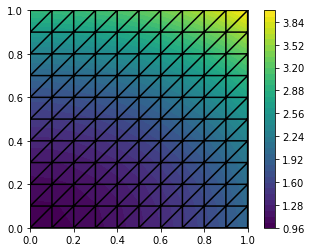

In [8]:
a = ufl.lhs(F)
L = ufl.rhs(F)
problem = dolfinx.fem.LinearProblem(a, L, bcs=bcs,
petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()
import dolfinx.plotting
min_color = min(uh.vector.array)
max_color = max(uh.vector.array)
c = dolfinx.plotting.plot(uh,vmin=min_color, vmax=max_color)
dolfinx.plotting.plot(mesh, color="k")
import matplotlib.pyplot as plt
plt.colorbar(c)
plt.show()

## Verification
As for the previous probles, we compute the error of our computed solution and compare it to the analytical solution.

In [9]:
# Compute L2 error and error at nodes
V_ex = dolfinx.FunctionSpace(mesh, ("CG", 2))
u_exact = dolfinx.Function(V_ex)
u_exact.interpolate(u_ex)
u_exact.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(dolfinx.fem.assemble_scalar((uh - u_exact)**2 * ufl.dx), op=MPI.SUM))
print("L2-error: {0:.2e}".format(error_L2))
# Compute values at mesh vertices
u_vertex_values = uh.compute_point_values()
u_ex_vertex_values = u_exact.compute_point_values()
max_local = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = mesh.mpi_comm().allreduce(max_local, op=MPI.MAX)
print("Error_max = {0:.2e}".format(error_max))

L2-error: 4.86e-03
Error_max = 2.07e-03
